In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import seaborn as sns
#import pmdarima as pm
from dateutil.relativedelta import relativedelta
import warnings
warnings.simplefilter(action='ignore')
from sklearn.metrics import accuracy_score
import time
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import prophet
from numpy import median
import math

In [2]:
import statistics

In [137]:
df = pd.read_csv('sales_train_validation.csv')
df.head(3)
calendar= pd.read_csv('calendar.csv')

In [138]:
df.drop(columns=['item_id', 'dept_id','cat_id','store_id','state_id'],axis=1, inplace=True) # Drop the unnecessary columns
data = df.T  # seting the days as index for new dataframe(Data)
data.columns = df['id'] # ading product id column to Data 
data.index.name = None   # remove the name of index
data.drop(index='id',inplace=True) # remove the first row
# change the format and the freq. of index to datetime format
data.index = calendar['date'][0:1913]
data.index = pd.to_datetime(data.index)
data.index.freq= 'd'
data.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-04-15', '2016-04-16', '2016-04-17', '2016-04-18',
               '2016-04-19', '2016-04-20', '2016-04-21', '2016-04-22',
               '2016-04-23', '2016-04-24'],
              dtype='datetime64[ns]', name='date', length=1913, freq='D')

In [180]:
start_interval = 250 # удаление начального интервала, в котором не отображаются данные о проданном товаре
test_sample= 100
train_SARIMA = data['FOODS_3_090_CA_3_validation'][start_interval:-test_sample].astype('float')
test_SARIMA = train_SARIMA[-test_sample:].astype('float')
train_LSTM = data['FOODS_3_090_CA_3_validation'][start_interval:-250].astype('float')
test_LSTM = data['FOODS_3_090_CA_3_validation'][:-test_sample].astype('float')
train_prophet = data[['FOODS_3_090_CA_3_validation']][start_interval:-test_sample].astype('float')
true = data['FOODS_3_090_CA_3_validation'][-test_sample:].astype('float')
print('full data length', data[['FOODS_3_090_CA_3_validation']][start_interval:].shape)
print('train_SARIMA', train_SARIMA.shape)
print('test_SARIMA', test_SARIMA.shape)
print('train_LSTM', train_LSTM.shape)
print('test_LSTM', test_LSTM.shape)
print("train prophet", train_prophet.shape)
print("true ", true.shape)

full data length (1663, 1)
train_SARIMA (1563,)
test_SARIMA (100,)
train_LSTM (1413,)
test_LSTM (1813,)
train prophet (1563, 1)
true  (100,)


In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [16]:
def holtWinters(data, seasonal_periods=12, trend='add', seasonal='add'):
    """
    This function fits a Holt-Winters exponential smoothing model to a time series data.
    
    Parameters:
    data (pandas.Series): The time series data to be modeled
    seasonal_periods (int): The number of seasonal periods in the data
    trend (str): The type of trend to be modeled. Can be 'add' or 'mul'
    seasonal (str): The type of seasonal component to be modeled. Can be 'add' or 'mul'
    
    Returns:
    statsmodels.tsa.holtwinters.ExponentialSmoothingResults: The fitted model object
    """
    try:
        # Check if data is a pandas Series
        if not isinstance(data, pd.Series):
            raise TypeError("Data must be a pandas Series")
        
        # Fit the model
        model = ExponentialSmoothing(data, seasonal_periods=seasonal_periods, trend=trend, seasonal=seasonal).fit()
        
        # Return the model object
        return model
    except TypeError as e:
        # Log the error
        print(f"Error: {e}")

In [129]:
data = df_to_series(true)

Error: Input must be a pandas DataFrame


In [181]:
forecast = holtWinters(train_LSTM, seasonal_periods=12, trend='add', seasonal='add')

In [182]:
forecast.params

{'smoothing_level': 0.393452372460113,
 'smoothing_trend': 0.0007030743334318623,
 'smoothing_seasonal': 0.055974653835277985,
 'damping_trend': nan,
 'initial_level': 251.14977950573552,
 'initial_trend': 0.1864922909359393,
 'initial_seasons': array([109.47819722,  -1.22531688, -16.09113102, -16.45368967,
         25.48460334, -63.64545757, -28.74413982,  10.05949424,
         17.31697791, -43.10819799,  -1.88993765,   8.88669277]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [188]:
forecast.fittedvalues

date
2011-10-06    360.814469
2011-10-07    206.272848
2011-10-08    210.354159
2011-10-09    308.453172
2011-10-10    296.116259
                 ...    
2015-08-14     71.868273
2015-08-15    103.536507
2015-08-16    127.423408
2015-08-17    148.597073
2015-08-18    129.763048
Freq: D, Length: 1413, dtype: float64

In [189]:
forecast.forecast(120)

2015-08-19    121.657219
2015-08-20    130.178535
2015-08-21    120.350870
2015-08-22    121.917929
2015-08-23    124.241648
                 ...    
2015-12-12    130.350654
2015-12-13    132.219304
2015-12-14    141.376121
2015-12-15    141.633899
2015-12-16    126.209014
Freq: D, Length: 120, dtype: float64

In [190]:
true = data[['FOODS_3_090_CA_3_validation']]['2015-10-12':].astype('float')

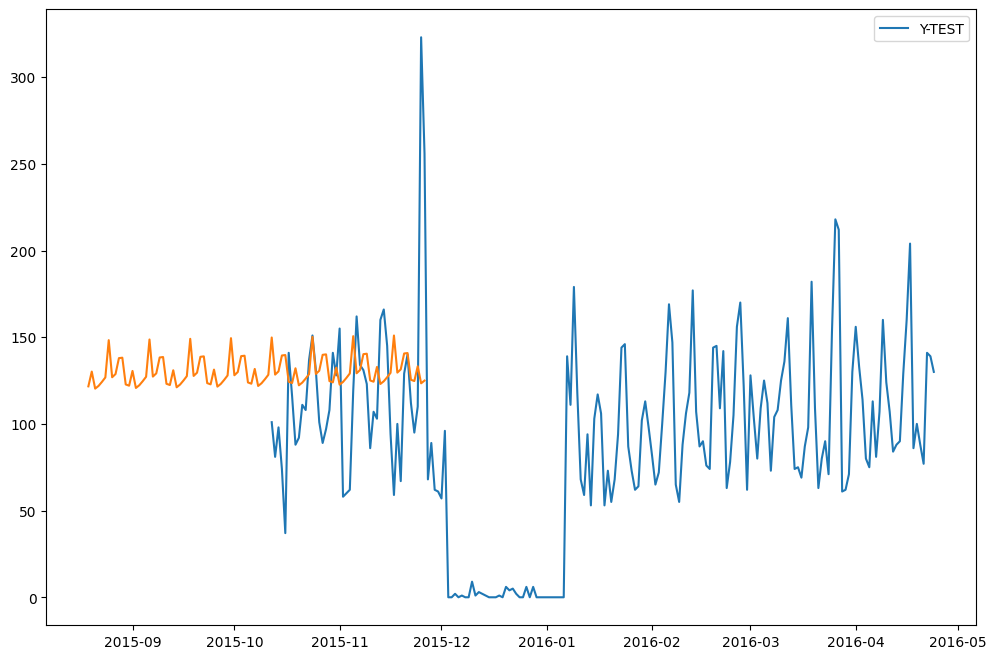

In [191]:

plt.figure(figsize=(12,8))
plt.plot(true, label='Y-TEST')
plt.plot(forecast.forecast(100))
plt.legend()
plt.show()

In [13]:
train_prophet = df_to_series(train_prophet)

In [192]:
metrics(test, forecast.forecast(len(test)))

NameError: name 'metrics' is not defined

In [12]:
def df_to_series(df):
    """
    This function takes a pandas DataFrame as input and returns a pandas Series.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to be converted to a Series
    
    Returns:
    pandas.Series: The Series obtained from the DataFrame
    """
    try:
        # Check if the input is a pandas DataFrame
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")
        
        # Convert the DataFrame to a Series and return it
        return df.squeeze()
    except TypeError as e:
        # Log the error
        print(f"Error: {e}")
        return pd.Series()

In [118]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def holt_winters_ext_regressors(data, event_calendar):
    """
    This function fits a Holt-Winters model with external regressors and event calendar to the given data.
    
    Parameters:
    data (pandas.DataFrame): The time series data to be modeled
    external_regressors (pandas.DataFrame): The external regressors to be used in the model
    event_calendar (pandas.DataFrame): The event calendar to be used in the model
    
    Returns:
    statsmodels.tsa.holtwinters.ExponentialSmoothingResultsWrapper: The fitted Holt-Winters model
    """
    try:
        # Check if all arguments are pandas DataFrames
        if not isinstance(data, pd.DataFrame) or not isinstance(event_calendar, pd.DataFrame):
            raise TypeError("All arguments must be pandas DataFrames")
        
        # Fit the Holt-Winters model with external regressors and event calendar
        model = ExponentialSmoothing(data, dates=event_calendar, seasonal_periods=12, trend='add', seasonal='add')
        fitted_model = model.fit()
         # Return the fitted model
        return fitted_model
    except TypeError as e:
        # Log the error
        print(f"Error: {e}")
        return None

In [119]:
train_prophet.index

DatetimeIndex(['2011-10-06', '2011-10-07', '2011-10-08', '2011-10-09',
               '2011-10-10', '2011-10-11', '2011-10-12', '2011-10-13',
               '2011-10-14', '2011-10-15',
               ...
               '2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09',
               '2016-01-10', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15'],
              dtype='datetime64[ns]', name='date', length=1563, freq='D')

In [125]:
hwH = holt_winters_ext_regressors(train_prophet,events_df['ds'])

Error: All arguments must be pandas DataFrames


In [121]:
def downcast(df):

    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()

    for i,t in enumerate(types):

        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)

        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)

        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')

    return df 

In [122]:
calendar = pd.read_csv("calendar.csv")

In [123]:
calendar = downcast(calendar)

In [124]:
# праздники
lst_events = calendar.event_name_1.dropna().unique().to_list()
events_df = pd.DataFrame(columns = ['event', 'ds'])
for strEvent in lst_events:
    events_df = events_df.append(pd.DataFrame({
        'event': strEvent,
        'ds': calendar.loc[(calendar[['event_name_1', 'event_name_2']] == strEvent).any(axis=1)].date.unique()
    }))
    
for strEvent in ['snap_CA','snap_TX','snap_WI']:
     events_df = events_df.append(pd.DataFrame({
        'event': strEvent,
        'ds': calendar.loc[(calendar[strEvent] > 0)].date.unique()
    }))

lst_events.extend(['snap_CA','snap_TX','snap_WI'])

events_df

,event,ds
0,SuperBowl,2011-02-06
1,SuperBowl,2012-02-05
2,SuperBowl,2013-02-03
3,SuperBowl,2014-02-02
4,SuperBowl,2015-02-01
...,...,...
645,snap_WI,2016-06-09
646,snap_WI,2016-06-11
647,snap_WI,2016-06-12
648,snap_WI,2016-06-14


In [104]:
events_df['ds'].set_index('ds')

AttributeError: 'Series' object has no attribute 'set_index'

In [114]:
events_df = series_to_dataframe(events_df)

Error: Argument must be a pandas series


In [117]:
events_df

In [113]:

def series_to_dataframe(series):
    """
    This function takes a pandas series as an argument and returns a pandas dataframe.
    
    Parameters:
    series (pandas.Series): The pandas series to be converted to a dataframe
    
    Returns:
    pandas.DataFrame: The dataframe created from the series
    """
    try:
        # Check if the argument is a pandas series
        if not isinstance(series, pd.Series):
            raise TypeError("Argument must be a pandas series")
        
        # Convert the series to a dataframe and return it
        return pd.DataFrame(series)
    except TypeError as e:
        # Log the error
        print(f"Error: {e}")
        return None